# 기본과제 1 : ResNet-34 implementation and fine-tuning


기본과제 1번에서는 ResNet-34 model을 구현해보고, QuickDraw dataset에 대해 직접 구현한 모델을 완전히 random 한 weight에서 시작하는(training from scratch) 학습을 해보게 됩니다. 또, torchvision에 내장된 ResNet-34의 pretrained weight를 불러와 적절한 수정을 통해 conv 부분은 고정하고, classification을 수행하는 마지막 layer 부분만 새로 학습하는 fine-tuning을 시도하며 training from scratch와의 차이점을 비교하게 됩니다.

과제 목표
- Pre-trained 네트워크를 활용 할 수 있다.
- Fine-tuning을 위해 네트워크의 일부를 고정하고 다른 일부만 학습할 수 있다.
- 네트워크를 일부 커스터마이즈해서 다른 문제에 적용할 수 있는 응용 능력을 갖춘다.


## Quickdraw dataset
Quickdraw dataset은 다양한 물체에 대한 간단한 sketch로 구성된 데이터셋입니다. [데이터셋 홈페이지](https://quickdraw.withgoogle.com/data)에서 예시 이미지들을 확인할 수 있으니, 데이터셋에 어떤 이미지들이 있는지 확인해보시기 바랍니다. 

이번 과제에서는 model을 보다 쉽게 구현할 수 있도록 데이터를 불러오는 과정에서 모든 이미지들을 (227 x 227)로 변경해줍니다. 또, 전체 class가 아닌 10개의 class만을 사용해 학습을 진행하게 됩니다.

아래 가려진 코드들은 필요한 패키지들을 import하고, QuickDraw dataset을 사용하기 위한 준비 코드들입니다. 코드가 꽤 길어 가려두었으며, 과제를 수행하기 위해 이해가 필수적인 코드는 아니지만 해당 과정을 이해하고 싶다면 코드를 확인해보셔도 좋습니다.


In [1]:
# install quickdraw python API
#!pip3 install quickdraw

In [2]:
# import packages
from quickdraw import QuickDrawData, QuickDrawDataGroup
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils
import itertools
import matplotlib.pyplot as plt
import os
import numpy as np
import torch.nn as nn
import pandas as pd
import random

from tqdm import tqdm

In [3]:
seed = 111

torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.cuda.manual_seed_all(seed)  # if use multi-GPU
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
np.random.seed(seed)
random.seed(seed)

In [4]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu") # device 객체
device

device(type='cuda', index=0)

In [5]:
num_img_per_class = 5000
qd = QuickDrawData(max_drawings=num_img_per_class)

In [6]:
class_list = ['apple', 'wine bottle', 'spoon', 'rainbow', 'panda', 'hospital', 'scissors', 'toothpaste', 'baseball', 'hourglass']
class_dict = {'apple' : 0, 'wine bottle' : 1, 'spoon' : 2, 'rainbow' : 3, 'panda': 4, 'hospital' : 5, 'scissors' : 6, 'toothpaste' : 7, 'baseball' : 8, 'hourglass' : 9}

In [7]:
qd.load_drawings(class_list)

loading apple drawings
load complete
loading wine bottle drawings
load complete
loading spoon drawings
load complete
loading rainbow drawings
load complete
loading panda drawings
load complete
loading hospital drawings
load complete
loading scissors drawings
load complete
loading toothpaste drawings
load complete
loading baseball drawings
load complete
loading hourglass drawings
load complete


In [8]:
# get images, and append to train/validation data and label list
train_data = list()
val_data = list()
train_label = list()
val_label = list()
for class_name in class_list:
  qdgroup = QuickDrawDataGroup(class_name, max_drawings=num_img_per_class)
  for i, img in enumerate(qdgroup.drawings):
    if i < int(0.9 * num_img_per_class):
      train_data.append(np.asarray(img.get_image()))
      train_label.append(class_dict[class_name])
    else:
      val_data.append(np.asarray(img.get_image()))
      val_label.append(class_dict[class_name])

loading apple drawings
load complete
loading wine bottle drawings
load complete
loading spoon drawings
load complete
loading rainbow drawings
load complete
loading panda drawings
load complete
loading hospital drawings
load complete
loading scissors drawings
load complete
loading toothpaste drawings
load complete
loading baseball drawings
load complete
loading hourglass drawings
load complete


In [9]:
# transformation, image to (227, 227) tensor

# NOTE : torchvision 0.8 이하에서 Tensor에 대해 transforms.Resize가 적용 불가능해 에러 발생
# torchvision update를 통해 문제를 해결하도록 안내!
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize((227,227)),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                          std=[0.229, 0.224, 0.225])
])

In [10]:
# custom dataset for Quickdraw
class QuickDrawDataset(Dataset):

    def __init__(self, data, labels, transform=None):
        self.data = data
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        img = self.data[idx]
        label = self.labels[idx]
        if self.transform:
          img = self.transform(img)
        return img, label

## To do (1) ResNet 구현
아래 table에서 34-layer를 구현하세요. 세부 layer가 논문과 동일하지 않아도 되지만, layer 갯수와 kernel size, output size는 지켜주세요.  

깃헙, 구글 등에 구현체를 최대한 보지 않고 구현해보세요, layer 마다 입력과 출력 차원을 하나씩 print 해보면서 layer를 구성해보시길 바랍니다.  
아래 네트워크 입력과 출력 차원을 지켜주세요. 
- input: (batch_size, 3, 227, 227)  
- output: (batch_size, 10(class 갯수))

논문을 참고해도 좋습니다. [ResNet paper](https://arxiv.org/pdf/1512.03385.pdf).  

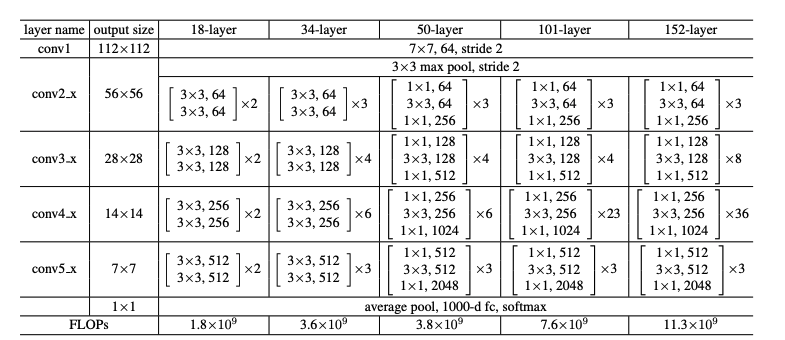

34-layer ResNet 같이 깊고 반복되는 네트워크를 구현할 때는 반복되는 작은 block 부터 구현해서 쌓아 올리는게 좋습니다.  

아래에 간단한 코드 구조를 제시해두었지만, 꼭 따르지 않아도 됩니다.  

### ConvBlock
Hint: conv + batchnorm + activation func(ReLU)

In [11]:
# ConvBlock(in_channels, nker=64, kernel_size=7, stride=2, padding=1)

class ConvBlock(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size=3, stride=1, padding=1):
        super().__init__()

        ##fill it##
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size, stride, padding, bias=False)
        self.bn = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU(inplace=True)

    def forward(self, x):
        
        ##fill it##
        x = self.conv(x)
        x = self.bn(x)
        x = self.relu(x)
        
        return x

### ResBlock
Hint: ConvBlock + ConvBlock + residual connection(with short cut) 
  
  
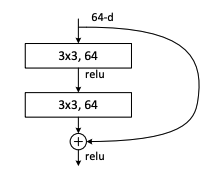

In [12]:
# ConvBlock(in_channels, nker=64, kernel_size=7, stride=2, padding=1)
class ResBlock(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size=3, stride=1, padding=1):
        super().__init__()

        ##fill##
        self.resblk = nn.Sequential(
            ConvBlock(in_channels, out_channels, kernel_size, stride, padding),
            nn.Conv2d(out_channels, out_channels, kernel_size, stride=1, padding=1, bias=False),
            nn.BatchNorm2d(out_channels)
        )
        
        self.skip_connection = nn.Sequential()
        
        if stride != 1 or in_channels != out_channels:
            self.skip_connection = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(out_channels)
            )
        
    def forward(self, x):
        
        ##fill##
        self.x = self.skip_connection(x)
        
        return self.x + self.resblk(x)

### ResNet 

In [13]:
class ResNet(nn.Module):
    def __init__(self, in_channels, out_channels, nker=64, nblk=[3,4,6,3]):
        super(ResNet, self).__init__()

        self.enc = ConvBlock(in_channels, nker, kernel_size=7, stride=2, padding=1)
        self.max_pool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)


        ##fill##
        self.nblk = nblk
        
        self.layer1 = ResBlock(nker, nker)
        self.layer2_begin = ResBlock(nker, nker*2, stride=2)
        self.layer2 = ResBlock(nker*2, nker*2)
        self.layer3_begin = ResBlock(nker*2, nker*2*2, stride=2)
        self.layer3 = ResBlock(nker*2*2, nker*2*2)
        self.layer4_begin = ResBlock(nker*2*2, nker*2*2*2, stride=2)
        self.layer4 = ResBlock(nker*2*2*2, nker*2*2*2)

        self.relu = nn.ReLU(inplace=True)

        self.average_pool = nn.AdaptiveAvgPool2d((1, 1))

        self.fc = nn.Linear(nker*2*2*2, 10)

    def forward(self, x):
        x = self.enc(x)
        x = self.max_pool(x)


        ##fill##
        for i in range(len(self.nblk)):
            for j in range(self.nblk[i]):
                if i == 0:
                    x = self.layer1(x)
                    #x = self.relu(x)
                elif i == 1:
                    if j == 0:
                        x = self.layer2_begin(x)
                        #x = self.relu(x)
                    else:
                        x = self.layer2(x)
                        #x = self.relu(x)
                elif i == 2:
                    if j == 0:
                        x = self.layer3_begin(x)
                        #x = self.relu(x)
                    else:
                        x = self.layer3(x)
                        #x = self.relu(x)
                else:
                    if j == 0:
                        x = self.layer4_begin(x)
                        #x = self.relu(x)
                    else:
                        x = self.layer4(x)
                        #x = self.relu(x)
                        
                x = self.relu(x)
                

        x = self.average_pool(x)
        x = torch.flatten(x, 1)
        out = self.fc(x)

        return out

아래는 테스트 코드 입니다. 네트워크가 잘 구성되었다면 (batch_size, 10) 차원의 output이 나오면 됩니다.

In [14]:
# Network
model_test = ResNet(3, 10)

# Random input
x = torch.randn((4, 3, 227, 227))

# Forward
out = model_test(x)

# Check the output shape
print("Output tensor shape is :", out.shape)

Output tensor shape is : torch.Size([4, 10])


## Training custom ResNet-34 from scratch
이제 직접 구현한 ResNet-34을 학습시켜보겠습니다. 모델을 학습하기 위해,
1. DataLoader에서 image, label을 불러오고
2. model에 image를 foward한 이후 output logit과 label의 loss를 계산하고
3. loss를 통해 optimizer의 backward를 수행해 parameter를 업데이트하는

일반적인 학습 loop을 완성하게 됩니다.


In [15]:
# Build user-defined ResNet model
model_scratch = ResNet(3, 10)
model_scratch.cuda()
model_scratch

ResNet(
  (enc): ConvBlock(
    (conv): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
  )
  (max_pool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): ResBlock(
    (resblk): Sequential(
      (0): ConvBlock(
        (conv): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
      )
      (1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (skip_connection): Sequential()
  )
  (layer2_begin): ResBlock(
    (resblk): Sequential(
      (0): ConvBlock(
        (conv): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2),

In [16]:
# Loss function and Optimizer
from torch.optim import Adam

criterion = nn.CrossEntropyLoss()
optimizer = Adam(model_scratch.parameters(), lr=1e-4)

In [17]:
log_dir ='./log'

In [18]:
# quickdraw train/validatoin dataset and dataloader
qd_train_dataset = QuickDrawDataset(train_data, train_label, transform)
qd_val_dataset = QuickDrawDataset(val_data, val_label, transform)

qd_train_dataloader = DataLoader(qd_train_dataset, batch_size=64, shuffle=True)
qd_val_dataloader = DataLoader(qd_val_dataset, batch_size=64, shuffle=True)

In [19]:
# Misc
class AverageMeter(object):
  """Computes and stores the average and current value"""
  def __init__(self):
      self.reset()

  def reset(self):
    self.val = 0
    self.avg = 0
    self.sum = 0
    self.count = 0

  def update(self, val, n=1):
    self.val = val
    self.sum += val * n
    self.count += n
    self.avg = self.sum / self.count

## TO DO (2)
아래 구조를 참고하여 학습 코드를 구현 후 학습하세요.

*아래 구조를 바꿔도 되지만 scratch_train_log.csv 파일에 iter, loss 등 학습 내용을 꼭 기록해야 합니다.  

*어렵다면 아래 finetuning 코드를 참고해도 좋습니다. 

In [20]:
# Main
os.makedirs(log_dir, exist_ok=True)

with open(os.path.join(log_dir, 'scratch_train_log.csv'), 'w') as log:
  # Training
    model_scratch.train()
    for iter, (img, label) in enumerate(qd_train_dataloader):

        ##fill##
        img, label = img.float().cuda(), label.long().cuda()

        optimizer.zero_grad()
        
        pred_logit = model_scratch(img)

        loss = criterion(pred_logit, label)
        
        loss.backward()
        optimizer.step()
        
        pred_label = torch.argmax(pred_logit, 1)
        acc = (pred_label == label).sum().item() / len(img)
        
        train_loss = loss.item()
        train_acc = acc

        # Validation 
        if (iter % 20 == 0) or (iter == len(qd_train_dataloader)-1):
            model_scratch.eval()
            valid_loss, valid_acc = AverageMeter(), AverageMeter()

            for img, label in qd_val_dataloader:    

                ##fill##
                img, label = img.float().cuda(), label.long().cuda()
                
                with torch.no_grad():
                    pred_logit = model_scratch(img)
                
                loss = criterion(pred_logit, label) 
                
                pred_label = torch.argmax(pred_logit, 1)
                acc = (pred_label == label).sum().item() / len(img)
            

                valid_loss.update(loss.item(), len(img))
                valid_acc.update(acc, len(img))

            valid_loss = valid_loss.avg
            valid_acc = valid_acc.avg

            print("Iter [%3d/%3d] | Train Loss %.4f | Train Acc %.4f | Valid Loss %.4f | Valid Acc %.4f" %
                (iter, len(qd_train_dataloader), train_loss, train_acc, valid_loss, valid_acc))
      
            # Train Log Writing
            log.write('%d,%.4f,%.4f,%.4f,%.4f\n'%(iter, train_loss, train_acc, valid_loss, valid_acc))

/opt/conda/lib/python3.8/site-packages/torchvision/transforms/functional.py:126: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  ../torch/csrc/utils/tensor_numpy.cpp:189.)
  img = torch.from_numpy(pic.transpose((2, 0, 1))).contiguous()


Iter [  0/704] | Train Loss 2.4802 | Train Acc 0.0469 | Valid Loss 2.3032 | Valid Acc 0.1012
Iter [ 20/704] | Train Loss 2.0831 | Train Acc 0.2188 | Valid Loss 2.1542 | Valid Acc 0.1756
Iter [ 40/704] | Train Loss 2.0423 | Train Acc 0.1875 | Valid Loss 1.9047 | Valid Acc 0.2602
Iter [ 60/704] | Train Loss 1.7978 | Train Acc 0.4844 | Valid Loss 1.6752 | Valid Acc 0.4258
Iter [ 80/704] | Train Loss 1.5723 | Train Acc 0.5000 | Valid Loss 1.5758 | Valid Acc 0.4390
Iter [100/704] | Train Loss 1.8397 | Train Acc 0.4844 | Valid Loss 1.4539 | Valid Acc 0.5216
Iter [120/704] | Train Loss 1.3884 | Train Acc 0.5938 | Valid Loss 1.3324 | Valid Acc 0.5828
Iter [140/704] | Train Loss 1.6482 | Train Acc 0.4844 | Valid Loss 1.3555 | Valid Acc 0.5340
Iter [160/704] | Train Loss 1.0684 | Train Acc 0.5625 | Valid Loss 1.1139 | Valid Acc 0.6558
Iter [180/704] | Train Loss 0.9286 | Train Acc 0.7031 | Valid Loss 1.0558 | Valid Acc 0.6652
Iter [200/704] | Train Loss 1.1478 | Train Acc 0.6875 | Valid Loss 1.0

## Fine-tuning ResNet-34 with pretrained feature extractor
이번에는 torchvision에서 제공하는 pretrained ResNet-34 을 이용한 fine-tuning 학습을 진행하게 됩니다. Fine-tuning의 경우도 기본적인 training 방법은 동일하지만, 이번에는 모든 parameter를 처음부터 학습하는 대신 **feature extractor는 기존 학습된 상태에서 고정하고 linear classifier만 새로 학습**한다는 차이가 있습니다. 

## TO DO (3)
1. torchvision에서 resnet34 pretrained 모델을 불러와 모든 파라미터를 freeze 하고,   
2. 마지막 linear classifier를 10차원으로 mappping 하게 수정해주세요.

*마지막 layer는 학습 가능해야합니다.

In [21]:
from torchvision.models import resnet34


##fill##
model_finetune = resnet34(pretrained=True)

for param in model_finetune.parameters():
    param.requires_grad_(False)

model_finetune.fc = nn.Linear(model_finetune.fc.in_features, 10)
model_finetune.cuda()

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [22]:
# Loss function and Optimizer
from torch.optim import Adam

criterion = nn.CrossEntropyLoss()
optimizer_ft = Adam(model_finetune.parameters(), lr=1e-4)

In [23]:
# Main
os.makedirs(log_dir, exist_ok=True)

with open(os.path.join(log_dir, 'fine_tuned_train_log.csv'), 'w') as log:
  # Training
  model_finetune.train()
  for iter, (img, label) in enumerate(qd_train_dataloader):

    # 학습에 사용하기 위한 image, label 처리 (필요한 경우, data type도 변경해주세요)
    img, label = img.float().cuda(), label.long().cuda()

    # implementing zero_grad ~ step
    optimizer_ft.zero_grad()

    # 모델에 이미지 forward
    pred_logit = model_finetune(img)

    # loss 값 계산
    loss = criterion(pred_logit, label)

    # Backpropagation
    loss.backward()
    optimizer_ft.step()

    # Accuracy 계산
    pred_label = torch.argmax(pred_logit, 1)
    acc = (pred_label == label).sum().item() / len(img)

    train_loss = loss.item()
    train_acc = acc

    # Validation
    if (iter % 20 == 0) or (iter == len(qd_train_dataloader)-1):
      model_finetune.eval()
      valid_loss, valid_acc = AverageMeter(), AverageMeter()

      for img, label in qd_val_dataloader:
        # Validation에 사용하기 위한 image, label 처리 (필요한 경우, data type도 변경해주세요)
        img, label = img.float().cuda(), label.long().cuda()

        # 모델에 이미지 forward (gradient 계산 X)
        with torch.no_grad():
          pred_logit = model_finetune(img)

        # loss 값 계산
        loss = criterion(pred_logit, label)

        # Accuracy 계산
        pred_label = torch.argmax(pred_logit, 1)
        acc = (pred_label == label).sum().item() / len(img)

        valid_loss.update(loss.item(), len(img))
        valid_acc.update(acc, len(img))

      valid_loss = valid_loss.avg
      valid_acc = valid_acc.avg

      print("Iter [%3d/%3d] | Train Loss %.4f | Train Acc %.4f | Valid Loss %.4f | Valid Acc %.4f" %
            (iter, len(qd_train_dataloader), train_loss, train_acc, valid_loss, valid_acc))
      
      # Train Log Writing
      log.write('%d,%.4f,%.4f,%.4f,%.4f\n'%(iter, train_loss, train_acc, valid_loss, valid_acc))

Iter [  0/704] | Train Loss 2.6095 | Train Acc 0.1094 | Valid Loss 2.4917 | Valid Acc 0.0934
Iter [ 20/704] | Train Loss 2.3021 | Train Acc 0.1406 | Valid Loss 2.3294 | Valid Acc 0.1040
Iter [ 40/704] | Train Loss 2.1733 | Train Acc 0.2500 | Valid Loss 2.2342 | Valid Acc 0.1758
Iter [ 60/704] | Train Loss 2.1504 | Train Acc 0.2969 | Valid Loss 2.1504 | Valid Acc 0.2530
Iter [ 80/704] | Train Loss 2.1053 | Train Acc 0.3594 | Valid Loss 2.0689 | Valid Acc 0.3484
Iter [100/704] | Train Loss 2.0528 | Train Acc 0.4062 | Valid Loss 1.9908 | Valid Acc 0.4308
Iter [120/704] | Train Loss 1.9161 | Train Acc 0.4844 | Valid Loss 1.9197 | Valid Acc 0.4892
Iter [140/704] | Train Loss 1.8509 | Train Acc 0.5312 | Valid Loss 1.8489 | Valid Acc 0.5686
Iter [160/704] | Train Loss 1.8316 | Train Acc 0.5156 | Valid Loss 1.7853 | Valid Acc 0.5924
Iter [180/704] | Train Loss 1.7082 | Train Acc 0.6250 | Valid Loss 1.7215 | Valid Acc 0.6338
Iter [200/704] | Train Loss 1.7119 | Train Acc 0.6719 | Valid Loss 1.6

## Visualizing training results
아래 코드는 training from scratch와 fine tuning의 학습 경향을 비교할 수 있는 그래프를 출력해주는 코드입니다. 수렴 속도, accuracy 등 학습 결과에서 확인할 수 있는 정보들을 통해 from scratch, fine tuning중 어떤 방법이 더 우수한지, 또 그 이유는 무엇인지 자유롭게 생각해보고 캠퍼분들과 논의해보세요!

In [24]:
# Load log file
scratch_train_log = pd.read_csv(os.path.join(log_dir, 'scratch_train_log.csv'), index_col=0, header=None)
fine_tuned_train_log = pd.read_csv(os.path.join(log_dir, 'fine_tuned_train_log.csv'), index_col=0, header=None)

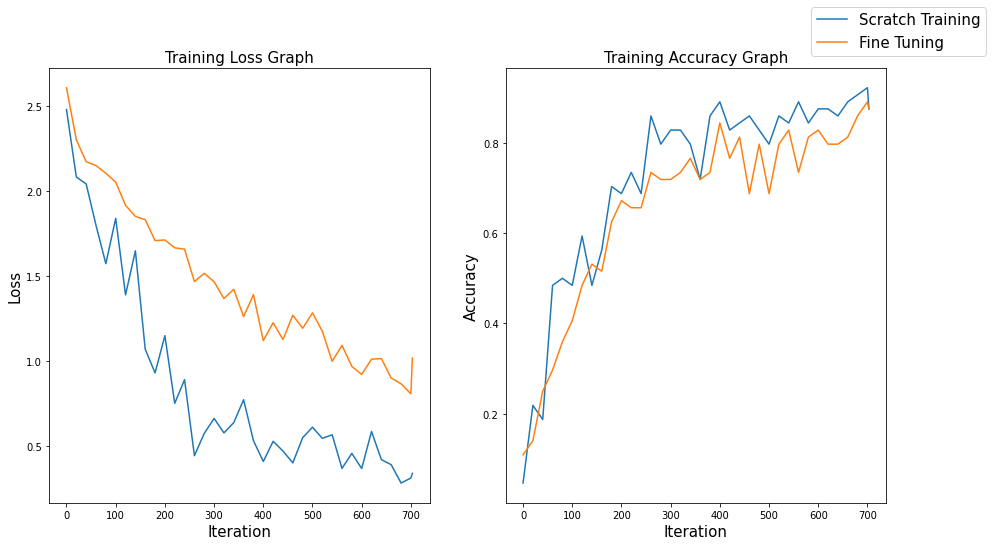

In [25]:
# Visualize training log
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15,8))

ax1.plot(scratch_train_log.iloc[:,0], label='Scratch Training')
ax1.plot(fine_tuned_train_log.iloc[:,0], label='Fine Tuning')
ax1.set_title('Training Loss Graph', fontsize=15)
ax1.set_xlabel('Iteration', fontsize=15)
ax1.set_ylabel('Loss', fontsize=15)

fig.legend(fontsize=15)

ax2.plot(scratch_train_log.iloc[:,1], label='Scratch Training')
ax2.plot(fine_tuned_train_log.iloc[:,1], label='Fine Tuning')
ax2.set_title('Training Accuracy Graph', fontsize=15)
ax2.set_xlabel('Iteration', fontsize=15)
ax2.set_ylabel('Accuracy', fontsize=15)

plt.show()

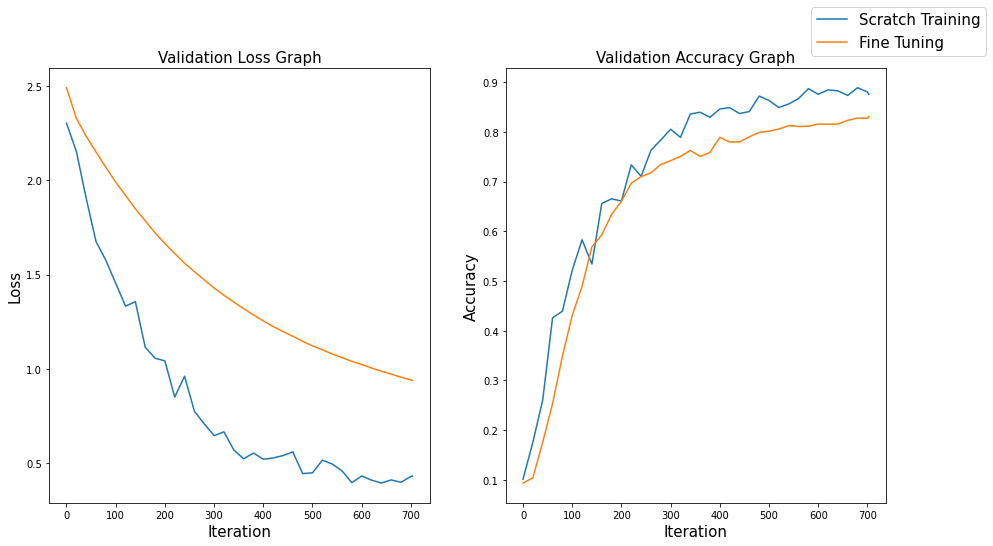

In [26]:
# Visualize validation log
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15,8))

ax1.plot(scratch_train_log.iloc[:,2], label='Scratch Training')
ax1.plot(fine_tuned_train_log.iloc[:,2], label='Fine Tuning')
ax1.set_title('Validation Loss Graph', fontsize=15)
ax1.set_xlabel('Iteration', fontsize=15)
ax1.set_ylabel('Loss', fontsize=15)

fig.legend(fontsize=15)

ax2.plot(scratch_train_log.iloc[:,3], label='Scratch Training')
ax2.plot(fine_tuned_train_log.iloc[:,3], label='Fine Tuning')
ax2.set_title('Validation Accuracy Graph', fontsize=15)
ax2.set_xlabel('Iteration', fontsize=15)
ax2.set_ylabel('Accuracy', fontsize=15)

plt.show()